In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import pearsonr

from q_sim import *
from q_fit import *
from q_sim_rw import *
from utils import *

import warnings
import multiprocessing as mp
import time
warnings.filterwarnings('ignore')

In [2]:
n_trials = 2_00
n_trials_per_block = 25
n_agent = 2_000

t_parameters = np.zeros(shape=(n_agent,2))
all_data = [] 

for agent in range(n_agent): # should change to 2000
    
    reward_probs = create_reward_probs(4,n_trials_per_block,n_trials,np.array([0.3,0.4,0.6,0.7]))
    param = configuration_parameters()
    
    sim = q_sim(
                agent,
                param,
                n_trials,
                reward_probs,
                probability_to_switch_parameters= 0.005, # 0 to check parameter recovery, 0.005 for non stationary
                max_change=np.random.choice([2]) #,3,4])
        )
    
    df = pd.DataFrame(sim)
    all_data.append(df)
    t_parameters[agent] = list(param.values())
    
df_all_agent = pd.concat(all_data)    
df_all_agent = df_all_agent.reset_index()
df_all_agent = df_all_agent.drop(columns=['index'])  

In [3]:
# recover parameters
start = time.time()
pool = mp.Pool(processes=mp.cpu_count())
fit_arr = pool.map(q_fit,all_data)
end = time.time()
print(end - start)
pool.close()

r_parameters = np.array([fit_arr[i].x for i in range(n_agent)])

23.461997270584106


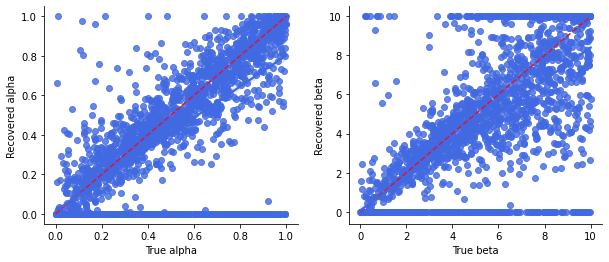

(0.6875669132810749, 5.129022299839844e-280)
(0.6880105042117617, 1.6119575772862385e-280)


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.lineplot(ax=ax1,x=[0,1],y=[0,1],ls='--',color='crimson')
sns.regplot(ax=ax1,x=t_parameters[:,0],y=r_parameters[:,0],color='royalblue')
ax1.set_xlabel('True alpha')
ax1.set_ylabel('Recovered alpha')

sns.lineplot(ax=ax2,x=[0,10],y=[0,10],ls='--',color='crimson')
sns.regplot(ax=ax2,x=t_parameters[:,1],y=r_parameters[:,1],color='royalblue')
ax2.set_xlabel('True beta')
ax2.set_ylabel('Recovered beta')

sns.despine()
plt.show()

print(pearsonr(x=t_parameters[:,0],y=r_parameters[:,0]))
print(pearsonr(x=t_parameters[:,1],y=r_parameters[:,1]))

In [3]:
results = q_fit(df_all_agent,num_of_parameters_to_recover=2)

In [ ]:
results

In [ ]:
tochdf_all_agent['state_onehot'][0]

In [ ]:
df_all_agent.iloc[:30]

In [5]:
# create a list of our conditions
x = 1/5
conditions = [
                (df_all_agent['alpha'] <= x), # 0
                (df_all_agent['alpha'] > 1*x) & (df_all_agent['alpha'] <= 2*x), # 1
                (df_all_agent['alpha'] > 2*x) & (df_all_agent['alpha'] <= 3*x), # 2
                (df_all_agent['alpha'] > 3*x) & (df_all_agent['alpha'] <= 4*x), # 3
                (df_all_agent['alpha'] > 4*x) # 4
    ]

# create a list of the values we want to assign for each condition
values = [0,1,2,3,4] 

# create a new column and use np.select to assign values to it using our lists as arguments
df_all_agent['alpha_categorical'] = np.select(conditions, values)

# create a list of our conditions
x = 10/5
conditions = [
                (df_all_agent['beta'] <= x), # 0
                (df_all_agent['beta'] > 1*x) & (df_all_agent['beta'] <= 2*x), # 1
                (df_all_agent['beta'] > 2*x) & (df_all_agent['beta'] <= 3*x), # 2
                (df_all_agent['beta'] > 3*x) & (df_all_agent['beta'] <= 4*x), # 3
                (df_all_agent['beta'] > 4*x) # 4
            ]

# create a list of the values we want to assign for each condition
values = [0,1,2,3,4]

# create a new column and use np.select to assign values to it using our lists as arguments
df_all_agent['beta_categorical'] = np.select(conditions, values)

In [6]:
df_all_agent[['agent','block','trial',
              'card_0', 'card_1', 'action','reward', 'state','state_onehot', 'alpha','beta',
              'alpha_categorical','beta_categorical']].to_csv('../data/artificial_trainset_2000_non_stat.csv',index=False)